# Exploratory Data Analysis
Following the Kaggle notebook

In [3]:
import time
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
# from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_pickle('../data/flight_delays.pkl')

In [5]:
df.head().T

,0,1,2,3,4
YEAR,2018,2018,2018,2018,2018
QUARTER,1,1,1,1,1
MONTH,1,1,1,1,1
DAY_OF_MONTH,1,1,2,2,3
DAY_OF_WEEK,1,1,2,2,3
FL_DATE,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-02 00:00:00,2018-01-02 00:00:00,2018-01-03 00:00:00
CARRIER,9E,9E,9E,9E,9E
FL_NUM,3331,3940,3409,3940,3353
ROUTE,42,42,42,42,42
ORIGIN,ABY,ABY,ABY,ABY,ABY


In [6]:
airports = pd.read_csv('../data/Airports.csv')

In [7]:
airports.head()

,Airport,City_State,State
0,ABE,"Allentown/Bethlehem/Easton, PA",PA
1,ABI,"Abilene, TX",TX
2,ABQ,"Albuquerque, NM",NM
3,ABR,"Aberdeen, SD",SD
4,ABY,"Albany, GA",GA


In [8]:
airfares = pd.read_csv('../data/AirFares.csv')

In [9]:
airfares.head()

,Year,quarter,Origin,Origin_State,Dest,Dest_State,nsmiles,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low
0,2018,1,ABE,PA,ATL,GA,692,286.40,DL,0.9455,287.18,AA,0.0339,263.31
1,2018,1,ABE,PA,BNA,TN,685,234.59,AA,0.5686,227.73,AA,0.5686,227.73
2,2018,1,ABE,PA,CLT,NC,481,289.19,AA,0.9518,288.46,AA,0.9518,288.46
3,2018,1,ABE,PA,DEN,CO,1539,263.12,UA,0.4737,255.18,UA,0.4737,255.18
4,2018,1,ABE,PA,DFW,TX,1307,261.68,AA,0.6448,260.94,UA,0.1081,200.66


In [10]:
print("Number of airports: {}".format(airports.shape[0]))

Number of airports: 362


In [11]:
routes = pd.read_csv('../data/Routes.csv')

In [12]:
routes.head()

,Route,ORIGIN,ORIGIN_City_State,Origin_City,Origin_State,DEST,Dest_City_State,Dest_City,Dest_State,DISTANCE
0,1,ABE,"Allentown/Bethlehem/Easton, PA",Allentown/Bethlehem/Easton,PA,ATL,"Atlanta, GA",Atlanta,GA,692
1,2,ABE,"Allentown/Bethlehem/Easton, PA",Allentown/Bethlehem/Easton,PA,BNA,"Nashville, TN",Nashville,TN,685
2,3,ABE,"Allentown/Bethlehem/Easton, PA",Allentown/Bethlehem/Easton,PA,CLT,"Charlotte, NC",Charlotte,NC,481
3,4,ABE,"Allentown/Bethlehem/Easton, PA",Allentown/Bethlehem/Easton,PA,DTW,"Detroit, MI",Detroit,MI,425
4,5,ABE,"Allentown/Bethlehem/Easton, PA",Allentown/Bethlehem/Easton,PA,FLL,"Fort Lauderdale, FL",Fort Lauderdale,FL,1041


In [13]:
print("Number of routes: {}".format(routes.shape[0]))

Number of routes: 6684


## Comparing Airlines
**1. Comparing airlines by their punctuality**

In [14]:
df['DEP_DELAY'] = df['DEP_DELAY'].replace(-9999, np.nan)

In [15]:
print("Number of unique flight numbers: ", df['FL_NUM'].nunique())

Number of unique flight numbers:  7148


In [16]:
print("Number of unique carriers: ", df['CARRIER'].nunique())

Number of unique carriers:  17


In [17]:
def get_stats(group):
    """ Extracts the stastistical parameters from a groupby object
    """
    return {'min': group.min(), 'max': group.max(),
           'count': group.count(), 'mean': group.mean(),
           'median': group.median()}

In [18]:
global_stats = df['DEP_DELAY'].groupby(df['CARRIER']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,count,max,mean,median,min
CARRIER,,,,,
HA,125962.0,2482.0,0.997460,-4.0,-37.0
G4,149301.0,1528.0,11.858414,-2.0,-53.0
F9,179724.0,1254.0,18.346860,-1.0,-60.0
EV,261425.0,1839.0,13.740013,-4.0,-36.0
NK,271763.0,1527.0,10.403870,-3.0,-47.0
YV,317331.0,2209.0,12.083799,-3.0,-35.0
9E,357702.0,1659.0,11.184880,-4.0,-38.0
AS,370854.0,1117.0,3.211385,-4.0,-114.0
OH,405872.0,1157.0,11.534336,-2.0,-35.0


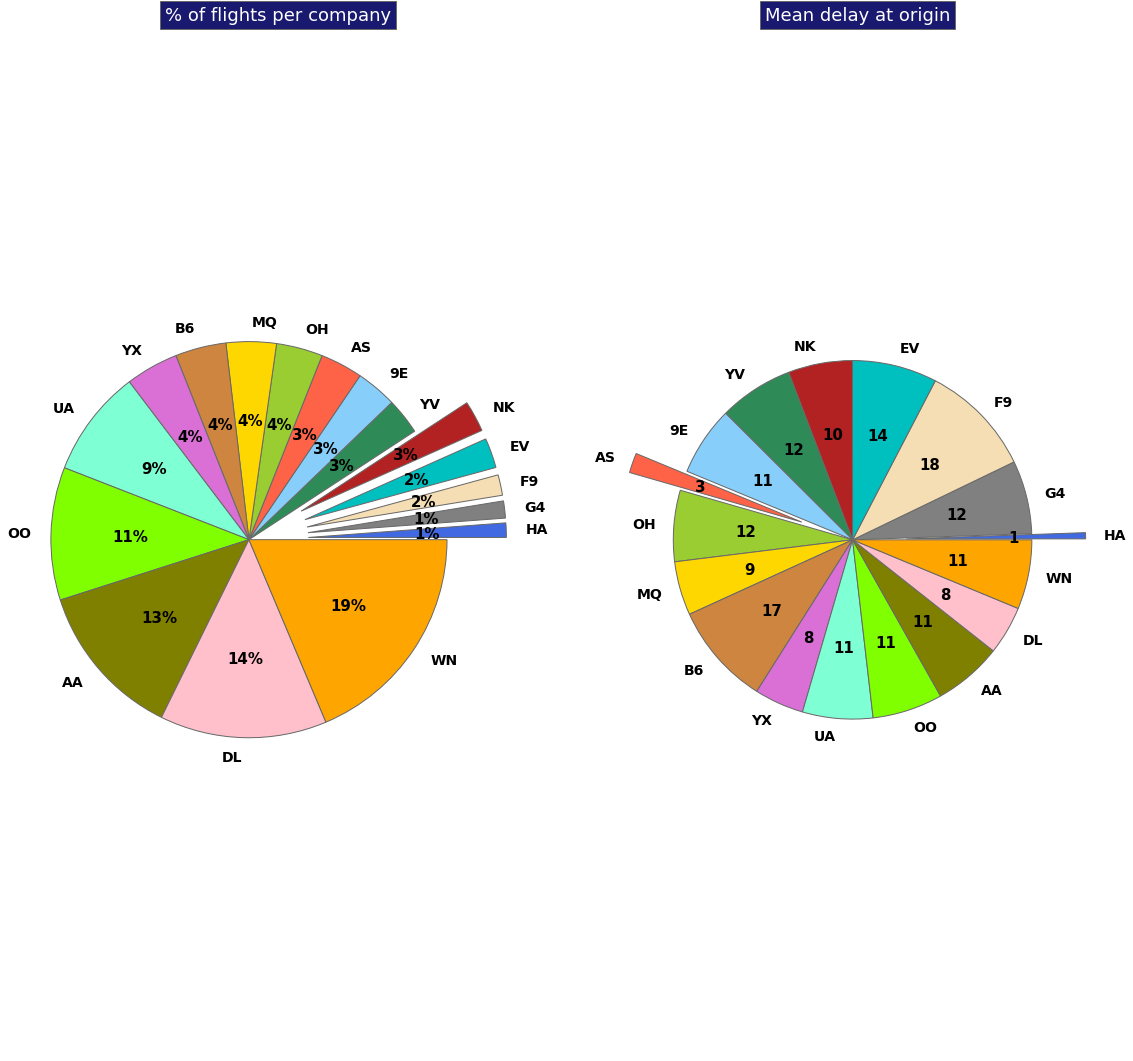

In [31]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
abbr_companies = df['CARRIER'].unique()
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = df.loc[:, ['CARRIER', 'DEP_DELAY']]
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'tomato', 'yellowgreen', 'gold', 'peru', 'orchid', 'aquamarine', 'chartreuse',
          'olive', 'pink', 'orange']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(1,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1])
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 300000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = abbr_companies[i]))
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.3 if sizes[i] < 5 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
plt.tight_layout(w_pad=3)